# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.6.0-kappa.new.72.167.176.191.fix.120.155.157.163.164.165.174.188'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
176775,2020-08-11,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176776,2020-08-12,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176777,2020-08-13,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176778,2020-08-14,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176779,2020-08-15,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
176775,2020-08-11,Colombia,Vichada,6,4,0,2
176776,2020-08-12,Colombia,Vichada,6,4,0,2
176777,2020-08-13,Colombia,Vichada,6,4,0,2
176778,2020-08-14,Colombia,Vichada,6,1,0,5
176779,2020-08-15,Colombia,Vichada,6,1,0,5


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
209,2020-08-11,16252,3946,336,11970
210,2020-08-12,16474,3918,336,12220
211,2020-08-13,16680,3816,338,12526
212,2020-08-14,17069,3883,338,12848
213,2020-08-15,17069,3883,338,12848


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-08-11,20337537,7071676,744403,12521458,0.018301,0.307841,0.056114
2020-08-12,20617054,7109156,751073,12756825,0.018215,0.309376,0.055603
2020-08-13,20926837,7251225,760748,12914864,0.018176,0.308572,0.055628
2020-08-14,20986047,7226279,761957,12997811,0.018154,0.309677,0.055376
2020-08-15,20986048,7263751,761957,12960340,0.018154,0.308785,0.055527


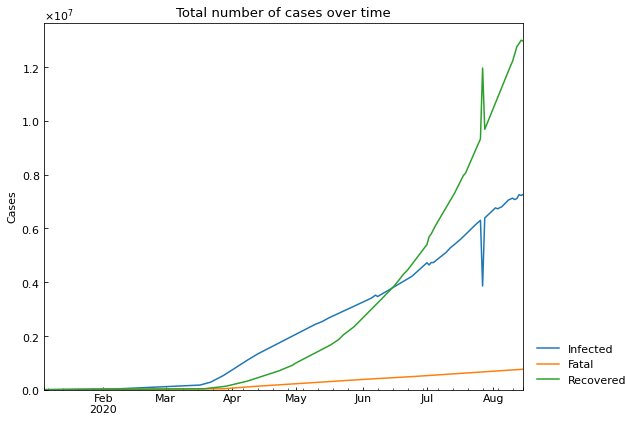

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
220,2020-08-11,50382,15366,1060,33956
221,2020-08-12,51360,15420,1065,34875
222,2020-08-13,52534,15344,1076,36114
223,2020-08-14,53894,15337,1086,37471
224,2020-08-15,53895,52809,1086,37008


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
167,2020-07-27,29969,6857,996,22116
168,2020-07-28,30961,7152,998,22811
169,2020-07-29,31901,7393,1001,23507
170,2020-07-30,33049,7866,1004,24179
171,2020-07-31,34372,8437,1006,24929


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
176775,2020-08-11,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176776,2020-08-12,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176777,2020-08-13,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176778,2020-08-14,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176779,2020-08-15,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
173351,COL,Colombia,Vichada,2020-08-11,107808
173352,COL,Colombia,Vichada,2020-08-12,107808
173353,COL,Colombia,Vichada,2020-08-13,107808
173354,COL,Colombia,Vichada,2020-08-14,107808
173355,COL,Colombia,Vichada,2020-08-15,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
176775,2020-08-11,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176776,2020-08-12,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176777,2020-08-13,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176778,2020-08-14,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
176779,2020-08-15,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
176775,2020-08-11,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
176776,2020-08-12,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
176777,2020-08-13,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
176778,2020-08-14,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
176779,2020-08-15,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
220,2020-08-11,1,1,1,0,0,1,1,3,2,2,1,30.56
221,2020-08-12,1,1,1,0,0,1,1,3,2,2,1,30.56
222,2020-08-13,1,1,1,0,0,1,1,3,2,2,1,30.56
223,2020-08-14,1,1,1,0,0,1,1,3,2,2,1,30.56
224,2020-08-15,1,1,1,0,0,1,1,3,2,2,1,30.56


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
220,2020-08-11,1,1,1,0,0,1,1,3,2,2,1,30.56
221,2020-08-12,1,1,1,0,0,1,1,3,2,2,1,30.56
222,2020-08-13,1,1,1,0,0,1,1,3,2,2,1,30.56
223,2020-08-14,1,1,1,0,0,1,1,3,2,2,1,30.56
224,2020-08-15,1,1,1,0,0,1,1,3,2,2,1,30.56


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

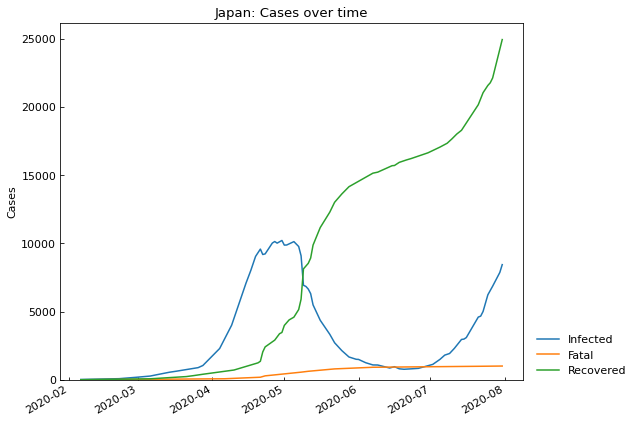

,Date,Confirmed,Infected,Fatal,Recovered
167,2020-07-27,29969,6857,996,22116
168,2020-07-28,30961,7152,998,22811
169,2020-07-29,31901,7393,1001,23507
170,2020-07-30,33049,7866,1004,24179
171,2020-07-31,34372,8437,1006,24929


In [26]:
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

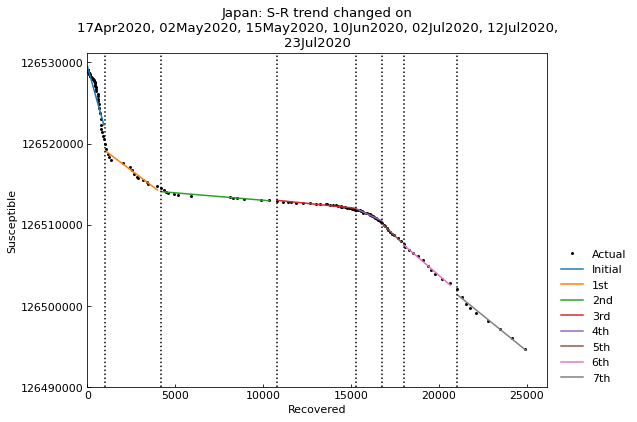

,Type,Start,End,Population
1st,Past,17Apr2020,01May2020,126529100
2nd,Past,02May2020,14May2020,126529100
3rd,Past,15May2020,09Jun2020,126529100
4th,Past,10Jun2020,01Jul2020,126529100
5th,Past,02Jul2020,11Jul2020,126529100
6th,Past,12Jul2020,22Jul2020,126529100
7th,Past,23Jul2020,31Jul2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	7th phase (23Jul2020 - 31Jul2020): finished  928 trials in 0 min 25 sec

	4th phase (10Jun2020 - 01Jul2020): finished  441 trials in 0 min 10 sec

	5th phase (02Jul2020 - 11Jul2020): finished  443 trials in 0 min 10 sec

	3rd phase (15May2020 - 09Jun2020): finished  954 trials in 0 min 25 sec

	2nd phase (02May2020 - 14May2020): finished 1835 trials in 1 min  0 sec

	1st phase (17Apr2020 - 01May2020): finished 1827 trials in 1 min  0 sec

	6th phase (12Jul2020 - 22Jul2020): finished 1875 trials in 1 min  0 sec

Completed optimization. Total: 1 min 46 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/beta [day],alpha1 [-],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,17Apr2020,01May2020,126529100,SIR-F,2.00,0.000299,0.000753,0.014476,0.006498,480,23,0.000,51,442,0.136012,1827,1 min 0 sec
1st,Past,02May2020,14May2020,126529100,SIR-F,0.21,0.051825,0.000568,0.004625,0.020161,480,72,0.052,16,586,0.154920,1835,1 min 0 sec
2nd,Past,15May2020,09Jun2020,126529100,SIR-F,0.20,0.100924,0.000638,0.005899,0.026441,480,56,0.101,12,522,0.111488,954,0 min 25 sec
3rd,Past,10Jun2020,01Jul2020,126529100,SIR-F,0.86,0.020953,0.000625,0.022549,0.025136,480,14,0.021,13,533,0.123667,441,0 min 10 sec
4th,Past,02Jul2020,11Jul2020,126529100,SIR-F,2.10,0.000078,0.000231,0.049821,0.023470,480,6,0.000,14,1441,0.028599,443,0 min 10 sec
5th,Past,12Jul2020,22Jul2020,126529100,SIR-F,2.00,0.000676,0.000021,0.044626,0.022286,480,7,0.001,14,15662,0.023234,1875,1 min 0 sec
6th,Past,23Jul2020,31Jul2020,126529100,SIR-F,1.88,0.000068,0.000078,0.046273,0.024516,480,7,0.000,13,4249,0.033589,928,0 min 25 sec


### Accuracy of estimation

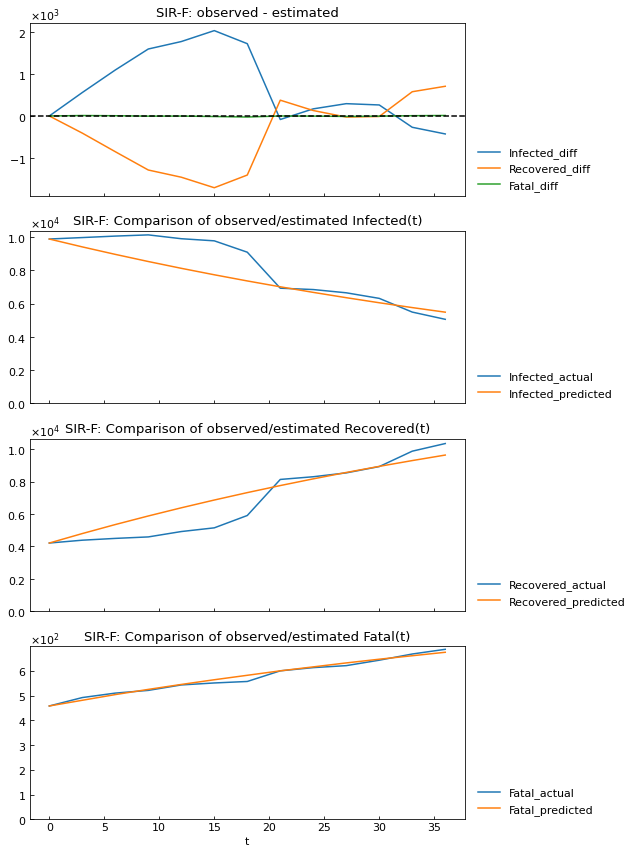

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

2.1

### Show parameter history

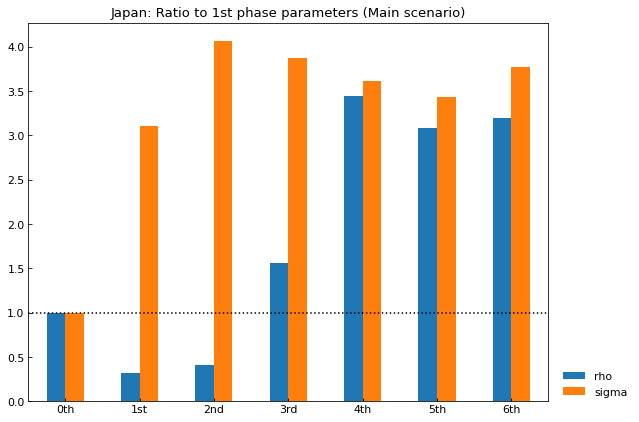

,0th,1st,2nd,3rd,4th,5th,6th
rho,1.0,0.319470,0.407499,1.557674,3.441583,3.082732,3.196519
sigma,1.0,3.102454,4.068999,3.868165,3.611699,3.429456,3.772676


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

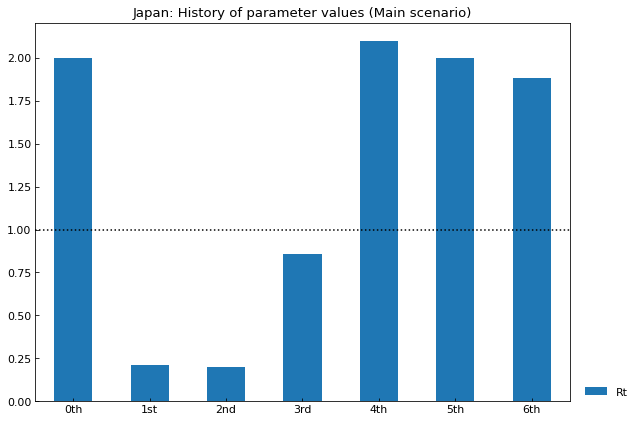

,0th,1st,2nd,3rd,4th,5th,6th
Rt,2.0,0.21,0.2,0.86,2.1,2.0,1.88


In [33]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

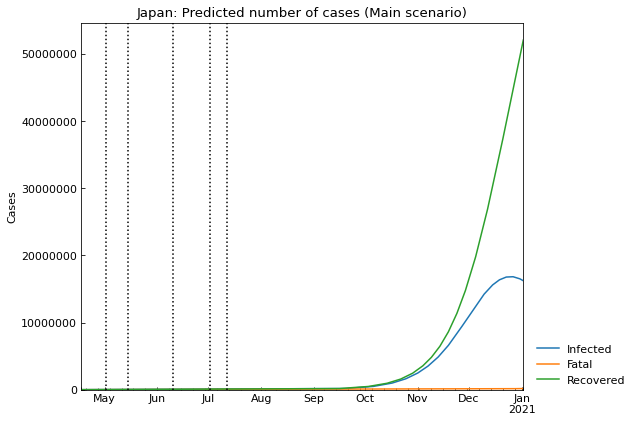

,Date,Confirmed,Fatal,Infected,Recovered
256,2020-12-29,64056740,156416,16703418,47196906
257,2020-12-30,65196154,160414,16613821,48421919
258,2020-12-31,66306843,164387,16502568,49639888
259,2021-01-01,67387560,168330,16370163,50849067
260,2021-01-02,68437119,172237,16217199,52047683


In [34]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [35]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.024515901161443848

In [36]:
sigma_new = sigma_current * 2
sigma_new

0.049031802322887695

In [37]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  17Apr2020  01May2020   126529100  SIR-F  2.00   
         1st      Past  02May2020  14May2020   126529100  SIR-F  0.21   
         2nd      Past  15May2020  09Jun2020   126529100  SIR-F  0.20   
         3rd      Past  10Jun2020  01Jul2020   126529100  SIR-F  0.86   
         4th      Past  02Jul2020  11Jul2020   126529100  SIR-F  2.10   
         5th      Past  12Jul2020  22Jul2020   126529100  SIR-F  2.00   
         6th      Past  23Jul2020  31Jul2020   126529100  SIR-F  1.88   
         7th    Future  01Aug2020  01Jan2021   126529100  SIR-F  1.88   
Medicine 0th      Past  17Apr2020  01May2020   126529100  SIR-F  2.00   
         1st      Past  02May2020  14May2020   126529100  SIR-F  0.21   
         2nd      Past  15May2020  09Jun2020   126529100  SIR-F  0.20   
         3rd      Past  10Jun2020  01Jul2020   126529100  SIR-F  0.86   
         4th      Past  02Jul2020  11Jul2020   126529100  SIR-F  2.10   
         5th      Past  12Jul2020  22Jul2020   126529100  SIR-F  2.00   
         6th      Past  23Jul2020  31Jul2020   126529100  SIR-F  1.88   
         7th    Future  01Aug2020  31Aug2020   126529100  SIR-F  1.88   
         8th    Future  01Sep2020  01Jan2021   126529100  SIR-F  0.94   

                   theta     kappa       rho     sigma  tau  1/beta [day]  \
Scenario Phase                                                              
Main     0th    0.000299  0.000753  0.014476  0.006498  480            23   
         1st    0.051825  0.000568  0.004625  0.020161  480            72   
         2nd    0.100924  0.000638  0.005899  0.026441  480            56   
         3rd    0.020953  0.000625  0.022549  0.025136  480            14   
         4th    0.000078  0.000231  0.049821  0.023470  480             6   
         5th    0.000676  0.000021  0.044626  0.022286  480             7   
         6th    0.000068  0.000078  0.046273  0.024516  480             7   
         7th    0.000068  0.000078  0.046273  0.024516  480             7   
Medicine 0th    0.000299  0.000753  0.014476  0.006498  480            23   
         1st    0.051825  0.000568  0.004625  0.020161  480            72   
         2nd    0.100924  0.000638  0.005899  0.026441  480            56   
         3rd    0.020953  0.000625  0.022549  0.025136  480            14   
         4th    0.000078  0.000231  0.049821  0.023470  480             6   
         5th    0.000676  0.000021  0.044626  0.022286  480             7   
         6th    0.000068  0.000078  0.046273  0.024516  480             7   
         7th    0.000068  0.000078  0.046273  0.024516  480             7   
         8th    0.000068  0.000078  0.046273  0.049032  480             7   

                alpha1 [-]  1/gamma [day]  1/alpha2 [day]      RMSLE Trials  \
Scenario Phase                                                                
Main     0th         0.000             51             442   0.136012   1827   
         1st         0.052             16             586    0.15492   1835   
         2nd         0.101             12             522   0.111488    954   
         3rd         0.021             13             533   0.123667    441   
         4th         0.000             14            1441  0.0285986    443   
         5th         0.001             14           15662  0.0232342   1875   
         6th         0.000             13            4249  0.0335894    928   
         7th         0.000             13            4249          -      -   
Medicine 0th         0.000             51             442   0.136012   1827   
         1st         0.052             16             586    0.15492   1835   
         2nd         0.101             12             522   0.111488    954   
         3rd         0.021             13             533   0.123667    441   
         4th         0.000             14            1441  0

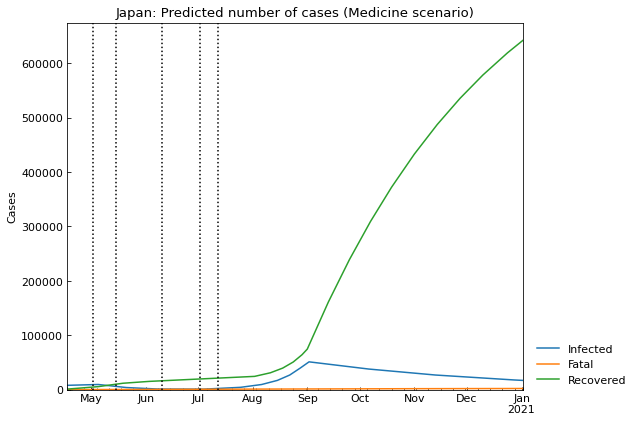

,Date,Confirmed,Fatal,Infected,Recovered
256,2020-12-29,652326,2190,17694,632442
257,2020-12-30,654759,2195,17531,635033
258,2020-12-31,657169,2199,17370,637600
259,2021-01-01,659556,2203,17210,640143
260,2021-01-02,661921,2207,17051,642663


In [38]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [39]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,8th_Rt
Main,16838447,26Dec2020,16217199,172237,-
Medicine,51631,01Sep2020,17051,2207,0.94
